# Sentiment analysis on the tweets during the 2020 USA presidential elections

### We will follow this steps: 
#### 1. Build a machine learning model able to find the sentiment of a text. 
#### 2. Apply it on selected tweets to get sentiment scores. 
#### 3. Display the results.

## 0) Imports

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from matplotlib import pyplot as plt
from textwrap import wrap
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import re
import nltk
nltk.download('stopwords', quiet=True)
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

## 1) Build a sentiment analysis machine learning model

### 1.A) Clean the dataset

In [4]:
df = pd.read_csv('Twitter_Data.csv')
df = df.drop_duplicates(subset=['clean_text'])

df["clean_text"] = df["clean_text"].str.replace('[^a-zA-Z- ]', '')
    
#data.isnull().sum()

### 1.B) Analyze the tweet dataset used to build our machine learning model.

#### First, we split the tweets by sentiment score (negative, neutral and positive) in order to display the number of tweets for each score. As we can see there is twice as many positive tweets than negative. This gap can influence our machine learning model so we have to keep it in mind.

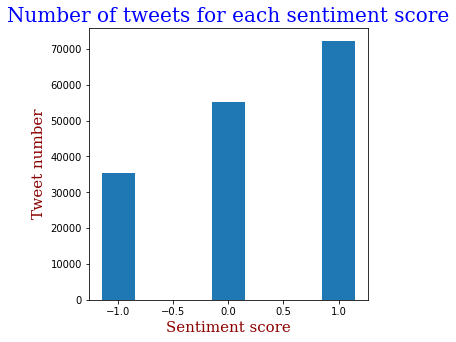

In [6]:
scores = [-1, 0, 1]
tweetsNeg = df[df["category"]==-1]
tweetsNeutral = df[df["category"]==0]
tweetsPos = df[df["category"]==1]

tweets = [len(tweetsNeg), len(tweetsNeutral), len(tweetsPos)]

font_title = {'family':'serif','color':'blue','size':20}
font_axis = {'family':'serif','color':'darkred','size':15}

plt.figure(figsize=(5,5))
plt.bar(scores, tweets, width = 0.3)
plt.title("Number of tweets for each sentiment score", fontdict=font_title)
plt.xlabel("Sentiment score", fontdict=font_axis)
plt.ylabel("Tweet number", fontdict=font_axis)
plt.show()

#### Secondly, we visualize the most common words for each tweet category. The wordclouds give us lexical fields for each sentiment score.

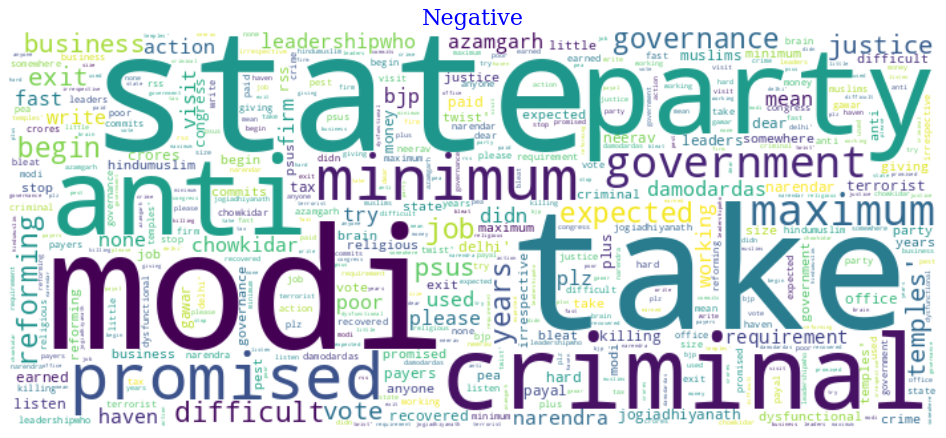

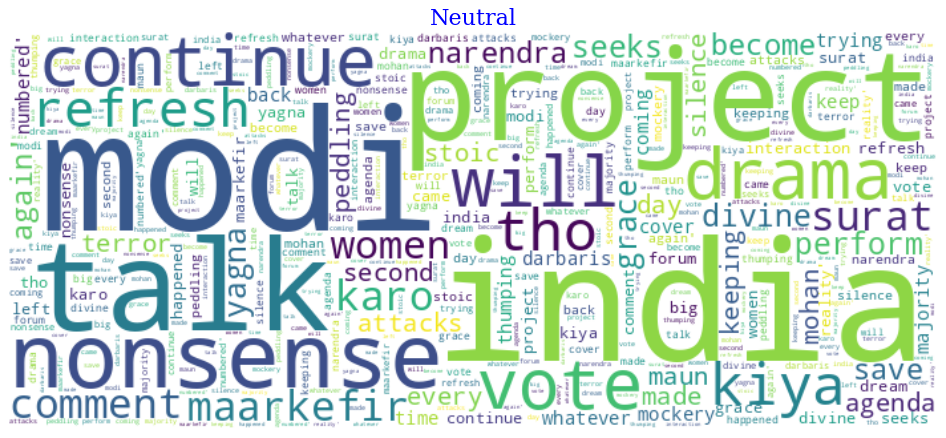

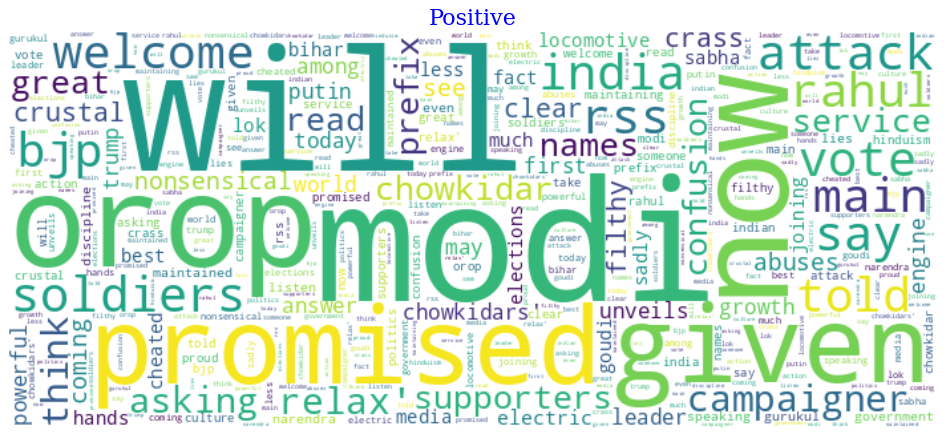

In [7]:
# Function to Create Wordcloud
def create_wordcloud(text, title):
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
    max_words=1000,
    stopwords=stopwords,
    random_state=42,
    width=700, height=300, repeat=True)
    wc.generate(str(text))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontdict=font_title)
    plt.show()

plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(tweetsNeg.values, "Negative")
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(tweetsNeutral.values, "Neutral")
plt.figure(figsize=(15, 8), dpi=80)
create_wordcloud(tweetsPos.values, "Positive")

#### We can observe the most common words are:
#### - "state", "anti", "criminal" for the negative tweets
#### - "india", "talk", project" for the neutral tweets
#### - "will", "promised", "given" for the positif tweets

### 1.C) Build the machine learning model

# Get the data

In [3]:
trump_dataset = pd.read_csv('hashtag_donaldtrump.csv', encoding='latin_1', lineterminator='\n')
biden_dataset = pd.read_csv('hashtag_joebiden.csv', encoding='latin_1', lineterminator='\n')

trump_dataset.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,ð Noticias de interÃ©s para latinos de la c...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump âs ...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - Ø±ÙØ§ Ø£Ø¨ØªØ±,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


# Clean the data

In [29]:
trump_dataset['reference'] = 'trump'
biden_dataset['reference'] = 'biden'

dataset = pd.concat([trump_dataset, biden_dataset])

dataset = dataset.drop(columns = ['collected_at', 'tweet_id', 'source', 'user_name', 'user_screen_name', 'user_description', 'user_join_date'])

dataset.sort_values(by='created_at')

dataset.head(20)

,created_at,tweet,likes,retweet_count,user_id,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,reference
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,3.606665e+08,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,trump
1,2020-10-15 00:00:01,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,3.316176e+08,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trump
2,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",2.0,1.0,8.436472e+06,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,trump
3,2020-10-15 00:00:02,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,8.283556e+17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trump
4,2020-10-15 00:00:08,You get a tie! And you get a tie! #Trump âs ...,4.0,3.0,4.741380e+07,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,trump
5,2020-10-15 00:00:17,@CLady62 Her 15 minutes were over long time ag...,2.0,0.0,1.138416e+09,2363.0,"Perris,California",33.782519,-117.228648,NaN,United States of America,North America,California,CA,trump
6,2020-10-15 00:00:17,@richardmarx Glad u got out of the house! DICK...,0.0,0.0,7.674018e+17,75.0,"Powell, TN",NaN,NaN,NaN,NaN,NaN,NaN,NaN,trump
7,2020-10-15 00:00:18,@DeeviousDenise @realDonaldTrump @nypost There...,0.0,0.0,9.007611e+17,766.0,"Ohio, USA",40.225357,-82.688140,NaN,United States of America,North America,Ohio,OH,trump
8,2020-10-15 00:00:20,One of the single most effective remedies to e...,0.0,0.0,5.404769e+08,151.0,"Pennsylvania, USA",40.969989,-77.727883,NaN,United States of America,North America,Pennsylvania,PA,trump
9,2020-10-15 00:00:21,#Election2020 #Trump \n#FreedomOfSpeech https:...,0.0,0.0,1.305533e+18,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trump


# Number of tweets for each hashtag

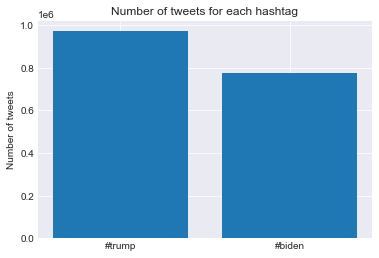

In [21]:
plt.style.use('seaborn-darkgrid')

x = ['#trump', '#biden']
nb_tweets_each_hashtag = [(dataset['reference'] == 'trump').sum(), (dataset['reference'] == 'biden').sum()]

x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, nb_tweets_each_hashtag, align='center')
plt.ylabel("Number of tweets")
plt.title("Number of tweets for each hashtag")

plt.xticks(x_pos, x)

plt.show()

# Number of null values

This analyse will give to us a more understanding about what pertinent graph can we made in order to have some interesting results.

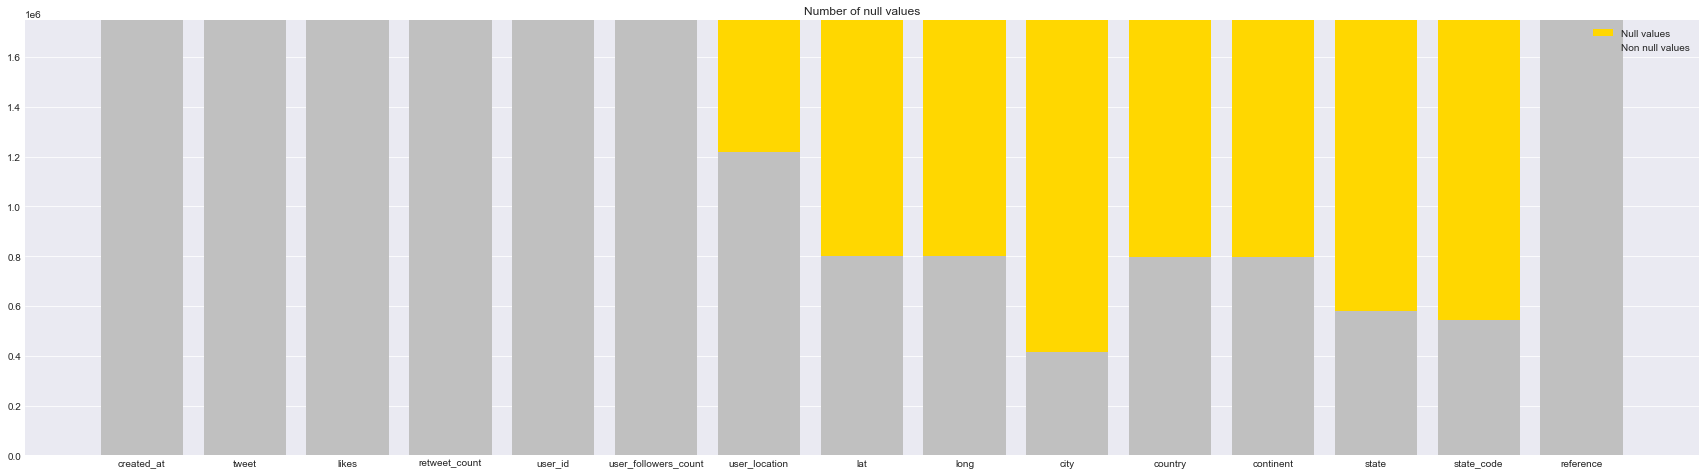

In [28]:
x = ['created_at', 'tweet', 'likes', 'retweet_count', 'user_id', 'user_followers_count', 'user_location', 'lat', 'long', 'city', 'country', 'continent', 'state', 'state_code', 'reference']

nb_tweets = len(dataset)
non_null_values = dataset.count().tolist()
null_values = [nb_tweets - value for value in non_null_values]

x_pos = [i for i, _ in enumerate(x)]

plt.figure(figsize=(30,8))
plt.bar(x_pos, null_values, width=0.8, label='Null values', color='gold', bottom=non_null_values)
plt.bar(x_pos, non_null_values, width=0.8, label='Non null values', color='silver')

plt.xticks(x_pos, x)
plt.title("Number of null values")
plt.legend()

plt.show()

This is not interesting to compare by city because there is a high number of null values. However, an analyse by country can be interesting to see from where come from the tweets. Maybe we can found some interesting results.


# Number of tweets by country




# Tweets qui ont le plus de likes entre biden et trump